# Imports

In [1]:
# same seed: any random numbers generated during the execution of the code will be reproducible
from numpy.random import seed
seed(888)
from tensorflow import random
random.set_seed(404)

In [84]:
import os 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools

import tensorflow as tf
import keras


from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

# image dataset were used cifar 10
from keras.datasets import cifar10

from IPython.display import display
from tensorflow.keras.preprocessing.image import array_to_img
from keras.callbacks import TensorBoard


from time import strftime

from sklearn.metrics import confusion_matrix

# Constants

In [79]:
LOG_DIR = 'tensorboard_cifar_logs/'

LABEL_NAMES = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
IMAGE_PIXELS = IMAGE_WIDTH * IMAGE_HEIGHT
COLOR_CHANNELS = 3
TOTAL_INPUTS = IMAGE_PIXELS * COLOR_CHANNELS
NR_CLASSES = 10

VALIDATAION_SIZE = 10000
SMALL_TRAIN_SIZE  = 1000

# Get the Data

In [4]:
# CIFAR-10
(x_train_all, y_train_all), (x_test, y_test) = cifar10.load_data()

In [5]:
type(cifar10)

module

In [6]:
type(x_train_all)

numpy.ndarray

# Explore the Data

In [7]:
x_train_all[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

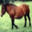

In [8]:
# in order to conver array to pic we use keras.preprocessing img_to_array
pic = array_to_img(x_train_all[7])
display(pic)

In [9]:
# we should be able to verify that this is indeed a horse by looking at the image labels which are found in the Y values.
y_train_all.shape
# we got numpy array of 50,000 labels and it's two dim

(50000, 1)

In [10]:
y_train_all[7][0]

7

In [11]:
LABEL_NAMES[y_train_all[7][0]]

'Horse'

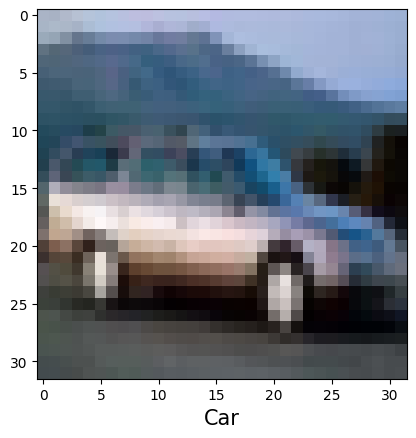

In [12]:
# use matplotlib
plt.imshow(x_train_all[4])
 #insert label
plt.xlabel(LABEL_NAMES[y_train_all[4][0]],fontsize=15)
plt.show()

**Challenge:** Write a for loop to display the first 10 images from the ```x_train_all``` array in a row. Show the name of the label below the picture. Remove the ugly tick marks. *Hint* use matplotlib. 

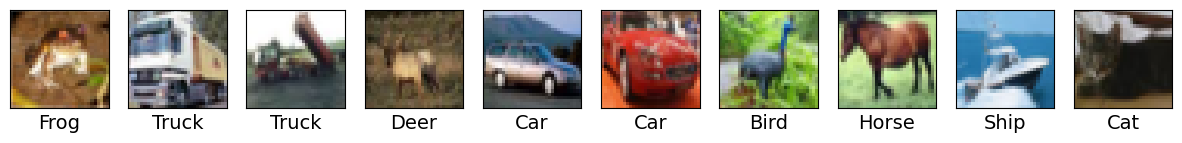

In [13]:
# the first 10 images in the training dataset
plt.figure(figsize=[15,5])

for i in range (10):
    plt.subplot(1,10,i+1)
    
    plt.xticks([]) # remove x,y ticks
    plt.yticks([])
    
    plt.xlabel(LABEL_NAMES[y_train_all[i][0]],fontsize=14)
    
    plt.imshow(x_train_all[i])

In [14]:
# how these images are formatted
x_train_all[0].shape #frog

(32, 32, 3)

In [15]:
# 4 dimension 50000 enteries,  
x_train_all.shape

(50000, 32, 32, 3)

In [16]:
nr_images, x, y, c = x_train_all.shape
print(f'images = {nr_images} \t| width = {x} \t| height = {y} \t| channels = {c}')

images = 50000 	| width = 32 	| height = 32 	| channels = 3


In [17]:
x_test.shape

(10000, 32, 32, 3)

# Preprocess Data

In [18]:
type(x_train_all[0][0][0][0])

numpy.uint8

In [19]:
# 255 is the largest value that I'm going to have because on the scale
# divide by 255 -> to get smaller value (easier later on for calculating the leraning rate and lost function and adjust them)
x_train_all, x_test = x_train_all / 255.0 , x_test/255.0

In [20]:
type(x_train_all[0][0][0][0])

numpy.float64

In [21]:
# put them in a single row(single vector)
# reshape (lenght, width*width*colorchannnels) i.e.,#32*32*3


# train dataset
x_train_all = x_train_all.reshape(x_train_all.shape[0],TOTAL_INPUTS )

In [22]:
x_train_all.shape

(50000, 3072)

In [23]:
# test dataset

x_test = x_test.reshape(x_test.shape[0],TOTAL_INPUTS) # x_test.shape[0] = len(x_test)
print(f'Shape of x_test is {x_test.shape}')

Shape of x_test is (10000, 3072)


### Create Validation Dataset

In [24]:
x_val = x_train_all[:VALIDATAION_SIZE]
y_val = y_train_all[:VALIDATAION_SIZE] 
x_val.shape
#y_val.shape

(10000, 3072)

**Challenge:** Create two numpy arrays ```x_train``` and ```y_train``` that have the shape (40000, 3072) and (40000, 1) respectively. They need to contain the last 40000 values from ```x_train_all``` and ```y_train_all``` respectively. 

In [25]:
x_train = x_train_all[VALIDATAION_SIZE:] # gives us the last 40000 value from x
x_train.shape

(40000, 3072)

In [26]:
y_train = y_train_all[VALIDATAION_SIZE:]
y_train.shape

(40000, 1)

### Create a small dataset (for illustration)

In [27]:
x_train_xs = x_train[:SMALL_TRAIN_SIZE] # take the fisrt 1000 value
y_train_xs = y_train[:SMALL_TRAIN_SIZE]

# Define the Neural Network using Keras

In [36]:
from keras.models import Sequential
from keras.layers import Dense, Activation


# Define the model
model_1 = Sequential([
    Dense(units=128, input_dim=TOTAL_INPUTS, activation='relu',name ='m1_hidden1'),
    Dense(units=64, activation = 'relu',name ='m1_hidden2'),
    Dense(16,activation='relu',name ='m1_hidden3'),
    Dense(10, activation='softmax',name ='m1_output')
])

# Compile the model
# 3 arguments: optimizer, the loss function, which metrics to calculate for optimizer

model_1.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']) 

In [37]:
#drop out on the input layer
model_2 = keras.Sequential()
model_2.add(Dropout(0.2,seed = 42, input_shape=(TOTAL_INPUTS,)))
model_2.add(Dense(128,activation = 'relu',name='m2_hidden1'))
model_2.add(Dense(64,activation = 'relu',name='m2_hidden2'))
model_2.add(Dense(16,activation = 'relu',name='m2_hidden3'))
model_2.add(Dense(10,activation = 'softmax',name='m2_output'))

model_2.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']) 

**Challenge:** Create a third model, ```model_3``` that has two dropout layers. The second dropout layer should be added after the first hidden layer and have a dropout rate of 25%. 

In [38]:
# drop out on both the input and the first hidden layer
model_3 = keras.Sequential()
model_3.add(Dropout(0.2,seed = 42, input_shape=(TOTAL_INPUTS,)))
model_3.add(Dense(128,activation = 'relu',name='m2_hidden1'))
model_3.add(Dropout(0.25,seed = 42))
model_3.add(Dense(64,activation = 'relu',name='m2_hidden2'))
model_3.add(Dense(16,activation = 'relu',name='m2_hidden3'))
model_3.add(Dense(10,activation = 'softmax',name='m2_output'))

model_3.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']) 

In [ ]:
type(model_1)

In [31]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m1_hidden1 (Dense)          (None, 128)               393344    
                                                                 
 m1_hidden2 (Dense)          (None, 64)                8256      
                                                                 
 m1_hidden3 (Dense)          (None, 16)                1040      
                                                                 
 m1_output (Dense)           (None, 10)                170       
                                                                 
Total params: 402,810
Trainable params: 402,810
Non-trainable params: 0
_________________________________________________________________


In [ ]:
32*32*3*128  # nr of connection weights

In [ ]:
393344-393216 # bias

In [ ]:
32*32*3*128 +128 + (128*64 + 64) + (64*16+ 16) + (16*10 + 10)

# Tensorboard (Visualizing Learning)

In [32]:
def get_tensorboard(model_name):

    folder_name = f'{model_name} at {strftime("%H %M")}'
    #print(folder_name)
    dir_paths = os.path.join(LOG_DIR, folder_name) # create directory and join with folder name

    try:
        os.makedirs(dir_paths)
    except OSError as err:
        print(err.strerror)
    else: 
        print('Successfully Created directory')
    
    return TensorBoard(log_dir = dir_paths)

In [ ]:
# https://keras.io/api/models/model_training_apis/#compile-method

# Fit the Model on small data set

In [33]:
samples_per_batch = 1000

In [34]:
%%time
nr_epochs = 150

model_1.fit(x_train_xs,y_train_xs,batch_size = samples_per_batch, epochs =nr_epochs,  
           callbacks=[get_tensorboard('Model 1')],verbose=0,validation_data=(x_val,y_val)) #we can use tensorboard as call back

Successfully Created directory
CPU times: total: 21.6 s
Wall time: 24.6 s


In [35]:
%%time
nr_epochs = 150

model_2.fit(x_train_xs,y_train_xs,batch_size = samples_per_batch, epochs =nr_epochs,  
            callbacks=[get_tensorboard('Model 2')],verbose=0,validation_data=(x_val,y_val))

Successfully Created directory
CPU times: total: 26.6 s
Wall time: 25.6 s


# Fit The model on the large data set

In [ ]:
# Recompile befor fitting

In [39]:
%%time
nr_epochs = 100

model_1.fit(x_train,y_train,batch_size = samples_per_batch, epochs =nr_epochs,  
           callbacks=[get_tensorboard('Model 1 XL')],verbose=0,validation_data=(x_val,y_val)) 

Successfully Created directory
CPU times: total: 5min 40s
Wall time: 3min 30s


In [40]:
%%time
nr_epochs = 100

model_2.fit(x_train,y_train,batch_size = samples_per_batch, epochs =nr_epochs,  
           callbacks=[get_tensorboard('Model 2 XL')],verbose=0,validation_data=(x_val,y_val)) 

Successfully Created directory
CPU times: total: 28min 48s
Wall time: 8min 16s


In [41]:
%%time
nr_epochs = 100

model_3.fit(x_train,y_train,batch_size = samples_per_batch, epochs =nr_epochs,  
           callbacks=[get_tensorboard('Model 3 XL')],verbose=0,validation_data=(x_val,y_val)) 

Successfully Created directory
CPU times: total: 12min 55s
Wall time: 5min 45s


# Make Predictions on individual Images

https://keras.io/api/models/model_training_apis/

In [42]:
# predict a single image

x_val.shape

(10000, 3072)

In [44]:
x_val[0].shape  #flattened, one dimensional array

(3072,)

In [46]:
# we need to expand it, to fit in the predict method, because normally we expect more than one image

test = np.expand_dims(x_val[0],axis=0)
test.shape

(1, 3072)

In [50]:
np.set_printoptions(precision=3)  #change the print option

In [51]:
model_2.predict(test) # individual array

1/1 [==============================] - 0s 27ms/step


array([[3.120e-02, 3.241e-03, 5.046e-02, 1.444e-01, 1.886e-01, 8.301e-02,
        4.783e-01, 1.976e-02, 2.326e-04, 7.898e-04]], dtype=float32)

In [ ]:
# why got probabilities= because has softmax in output layer for activation function

**Challenge:** Write a for loop where you print out the actual value and the predicted value for the first 10 images in the valuation dataset. 

In [52]:
model_2.predict(x_val)
model_2.predict(x_val).shape  # 10 probabailities, 1000 images on evaluation dataset

313/313 [==============================] - 0s 1ms/step


(10000, 10)

In [56]:
for i in range(10):
    test_img = np.expand_dims(x_val[i],axis=0)
    predicted_val = np.argmax(model_2.predict(test_img)[0])
    print(f'Actual value: {y_val[i][0]} vs. predicted: {predicted_val}')

1/1 [==============================] - 0s 16ms/step
Actual value: 6 vs. predicted: 6
1/1 [==============================] - 0s 22ms/step
Actual value: 9 vs. predicted: 1
1/1 [==============================] - 0s 17ms/step
Actual value: 9 vs. predicted: 9
1/1 [==============================] - 0s 17ms/step
Actual value: 4 vs. predicted: 6
1/1 [==============================] - 0s 21ms/step
Actual value: 1 vs. predicted: 8
1/1 [==============================] - 0s 16ms/step
Actual value: 1 vs. predicted: 9
1/1 [==============================] - 0s 19ms/step
Actual value: 2 vs. predicted: 2
1/1 [==============================] - 0s 18ms/step
Actual value: 7 vs. predicted: 7
1/1 [==============================] - 0s 18ms/step
Actual value: 8 vs. predicted: 8
1/1 [==============================] - 0s 24ms/step
Actual value: 3 vs. predicted: 9


In [57]:
# argmax return the index of the class with the highest probability

# Evaluation

In [58]:
model_2.metrics_names

['loss', 'accuracy']

In [62]:
test_loss, test_accuracy = model_2.evaluate(x_test, y_test)
print(f'Test loss is {test_loss:0.3} and test accuracy is {test_accuracy:0.1%}')

313/313 [==============================] - 1s 3ms/step - loss: 1.4327 - accuracy: 0.4901
Test loss is 1.43 and test accuracy is 49.0%


In [ ]:
# we have got an accuracy about 49% on our evaluation

## Confusion Matrix

In [67]:
from keras.utils import to_categorical

# Convert y_test to categorical labels
y_test_cat = to_categorical(y_test)

In [68]:
# Get model predictions
predictions = model_2.predict(x_test)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true=y_test_cat.argmax(axis=1), y_pred=predictions.argmax(axis=1))

313/313 [==============================] - 1s 2ms/step


In [69]:
conf_matrix.shape

(10, 10)

In [71]:
nr_rows = conf_matrix.shape[0]
nr_rows

10

In [72]:
nr_cols = conf_matrix.shape[1]
nr_cols

10

In [73]:
conf_matrix.max()

671

In [74]:
conf_matrix.min()

7

In [ ]:
# itertools -> functions for creating iterators, for efficient looping.

# Visualize Confusion Matrix

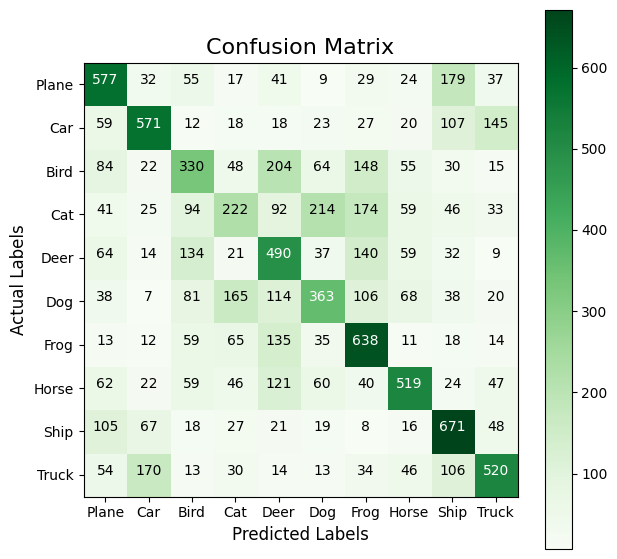

In [85]:
plt.figure(figsize=[7,7], dpi=95)  # dpi->resolution
plt.imshow(conf_matrix,cmap=plt.cm.Greens)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Labels', fontsize=12)
plt.xlabel('Predicted Labels', fontsize=12)

tick_marks = np.arange(NR_CLASSES)
plt.yticks(tick_marks, LABEL_NAMES)
plt.xticks(tick_marks, LABEL_NAMES)


plt.colorbar()

for i, j in itertools.product(range(nr_rows), range(nr_cols)):
    plt.text(j, i, conf_matrix[i, j], horizontalalignment='center',
            color='white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black')




plt.show()

**Challenge:** What do the numbers down the diagonal represent? What do the other numbers (excluding the number in the diagonal) in a single row represent? Try to identify the false positives, false negatives, and the true positives in the confusion matrix.

#The value long the diagonal is (True positive)

#The value down the **column**, our model predicted a plane but in fact it was a car **(false positive)**
#And if we sum all those values, excluding the value in the diagonal, then we get all the false positives
#for one particular category.

#**false negative**-> in a **row**, all these values represent the false negatives.
#Summing up the rows, excluding the diagonal, will give us the false negatives for a particular category.

In [86]:
# True Positives
np.diag(conf_matrix)

array([577, 571, 330, 222, 490, 363, 638, 519, 671, 520], dtype=int64)

In [87]:
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
recall

array([0.577, 0.571, 0.33 , 0.222, 0.49 , 0.363, 0.638, 0.519, 0.671,
       0.52 ])

In [88]:
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
precision

array([0.526, 0.606, 0.386, 0.337, 0.392, 0.434, 0.475, 0.592, 0.536,
       0.586])

In [89]:
avg_recall = np.mean(recall)
print(f'Model 2 recall score is {avg_recall:.2%}')

Model 2 recall score is 49.01%


**Challenge:** Calculate the average precision for the model as a whole. Print this out. Then calculate the f-score for the model as a whole. 

In [90]:
avg_precision = np.mean(precision)
print(f'Model 2 precision score is {avg_precision:.2%}')

f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)
print(f'Model 2 f score is {f1_score:.2%}')

Model 2 precision score is 48.69%
Model 2 f score is 48.85%
